In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 40.1 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import torchmetrics
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [ ]:
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transformation
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transformation
)

In [ ]:
dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=True)

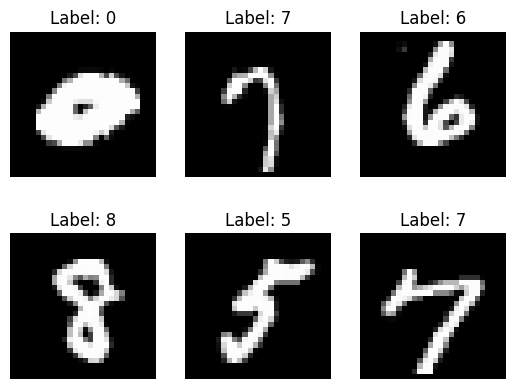

In [ ]:
data_iter = iter(dataloader_train)
images, labels = next(data_iter)

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.show()

In [ ]:
class SimpleCNN(torch.nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.feature_extractor = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, kernel_size=3, padding=1),
        torch.nn.ELU(),
        torch.nn.MaxPool2d(kernel_size=2),
        torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
        torch.nn.ELU(),
        torch.nn.MaxPool2d(kernel_size=2),
        torch.nn.Flatten()
    )

    self.classifier = torch.nn.Linear(64*7*7, num_classes)

  def forward(self, x):
    x = self.feature_extractor(x)
    x = self.classifier(x)
    return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
net = SimpleCNN(num_classes=10).to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=0.001)

train_loss = []

for epoch in range(10):
  net.train()
  epoch_loss = 0
  for images, labels in dataloader_train:
    images, labels = images.to(device), labels.to(device)
    output = net(images)
    loss = criterion(output, labels)
    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch_loss += loss.item()
  epoch_loss /= len(dataloader_train)
  train_loss.append(epoch_loss)
  print(f"Epoch [{epoch + 1}/{10}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 0.4717
Epoch [2/10], Loss: 0.1344
Epoch [3/10], Loss: 0.0663
Epoch [4/10], Loss: 0.0443
Epoch [5/10], Loss: 0.0239
Epoch [6/10], Loss: 0.0259
Epoch [7/10], Loss: 0.0231
Epoch [8/10], Loss: 0.0146
Epoch [9/10], Loss: 0.0171
Epoch [10/10], Loss: 0.0208


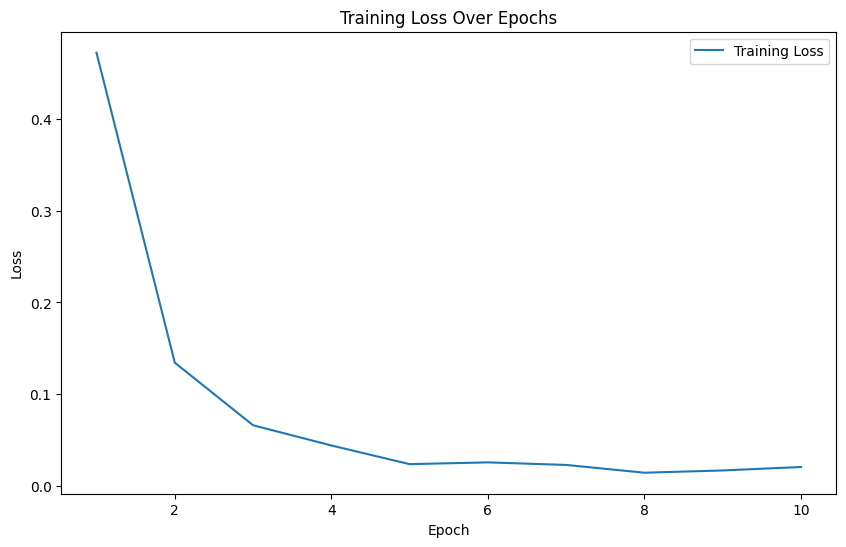

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), train_loss, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

In [ ]:
metric_accuracy = torchmetrics.Accuracy(
    task="multiclass",
    num_classes=10
).to(device)

metric_precision = torchmetrics.Precision(
    task="multiclass", num_classes=10, average="macro"
).to(device)

metric_recall = torchmetrics.Recall(
    task="multiclass", num_classes=10, average="macro"
).to(device)

In [ ]:
net.eval()
with torch.no_grad():
  for images, labels in dataloader_test:
    images, labels = images.to(device), labels.to(device)
    output = net(images)
    preds = torch.argmax(output, dim=1)
    metric_accuracy(preds, labels)
    metric_precision(preds, labels)
    metric_recall(preds, labels)

accuracy = metric_accuracy.compute()
precision = metric_precision.compute()
recall = metric_recall.compute()

In [ ]:
print(f"Accuracy: {precision}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.9909507632255554
Precision: 0.9909507632255554
Recall: 0.990948498249054
